# Employee Attrition

In [1]:
import pickle
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, shapiro, ttest_ind, mannwhitneyu, f_oneway, kruskal

In [2]:
df = pd.read_csv('../data/Employee Attrition.csv')
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [3]:
# Features are filtered based on the given requirements
mask = [
    # target
    'Attrition', 
    # categorical
    'Gender', 'Department', 'EducationField', 'JobRole', 'OverTime',
    # numerical
    'Age', 'DistanceFromHome', 'Education', 'EmployeeNumber', 'EnvironmentSatisfaction', 
    'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 
    'MonthlyRate', 'PerformanceRating', 'TotalWorkingYears', 'YearsAtCompany', 'YearsInCurrentRole'
]
df = df[mask]
df.head()

,Attrition,Gender,Department,EducationField,JobRole,OverTime,Age,DistanceFromHome,Education,EmployeeNumber,...,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,PerformanceRating,TotalWorkingYears,YearsAtCompany,YearsInCurrentRole
0,Yes,Female,Sales,Life Sciences,Sales Executive,Yes,41,1,2,1,...,94,3,2,4,5993,19479,3,8,6,4
1,No,Male,Research & Development,Life Sciences,Research Scientist,No,49,8,1,2,...,61,2,2,2,5130,24907,4,10,10,7
2,Yes,Male,Research & Development,Other,Laboratory Technician,Yes,37,2,2,4,...,92,2,1,3,2090,2396,3,7,0,0
3,No,Female,Research & Development,Life Sciences,Research Scientist,Yes,33,3,4,5,...,56,3,1,3,2909,23159,3,8,8,7
4,No,Male,Research & Development,Medical,Laboratory Technician,No,27,2,1,7,...,40,3,1,2,3468,16632,3,6,2,2


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Attrition                1470 non-null   object
 1   Gender                   1470 non-null   object
 2   Department               1470 non-null   object
 3   EducationField           1470 non-null   object
 4   JobRole                  1470 non-null   object
 5   OverTime                 1470 non-null   object
 6   Age                      1470 non-null   int64 
 7   DistanceFromHome         1470 non-null   int64 
 8   Education                1470 non-null   int64 
 9   EmployeeNumber           1470 non-null   int64 
 10  EnvironmentSatisfaction  1470 non-null   int64 
 11  HourlyRate               1470 non-null   int64 
 12  JobInvolvement           1470 non-null   int64 
 13  JobLevel                 1470 non-null   int64 
 14  JobSatisfaction          1470 non-null  

In [5]:
print('Check for null values:')
df.isnull().sum()

Check for null values:


Attrition                  0
Gender                     0
Department                 0
EducationField             0
JobRole                    0
OverTime                   0
Age                        0
DistanceFromHome           0
Education                  0
EmployeeNumber             0
EnvironmentSatisfaction    0
HourlyRate                 0
JobInvolvement             0
JobLevel                   0
JobSatisfaction            0
MonthlyIncome              0
MonthlyRate                0
PerformanceRating          0
TotalWorkingYears          0
YearsAtCompany             0
YearsInCurrentRole         0
dtype: int64

**Utils**

In [6]:
def annotate_bars(ax, category_count):
    total = category_count.sum()
    for p in ax.patches:
        count = int(p.get_height())
        percentage = f'{100 * count / total:.1f}%'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        annotation = f'{count} ({percentage})'
        ax.annotate(annotation, (x, y), ha='center', va='bottom')

In [7]:
def plot_histogram(df, column, bins='auto', title=None, save=False, path=None):
    if column not in df.columns:
        raise ValueError(f"Column '{column}' not found in the DataFrame.")

    sns.histplot(df[column], kde=True, bins=bins)
    column_name = column.replace('_', ' ').title()
    plot_title = title if title else f'Distribution of {column_name}'
    plt.title(plot_title)
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.tight_layout()

    if save and path:
        plt.savefig(path)
    plt.show()

In [8]:
def plot_countdist(df, column, rotation=0, top_n=None, title=None, save=False, path=None):
    if column not in df.columns:
        raise ValueError(f"Column '{column}' not found in the DataFrame.")

    category_count = df[column].value_counts()
    category_order = category_count.nlargest(
        top_n
    ).index if top_n else category_count.index

    ax = sns.countplot(x=column, data=df, order=category_order)
    annotate_bars(ax, category_count)

    column_name = column.replace('_', ' ').title()
    plot_title = title if title else f'Distribution of {column_name}'
    plt.title(plot_title)
    plt.xticks(rotation=rotation)
    plt.xlabel(column_name)
    plt.ylabel('Count')
    plt.tight_layout()

    if save and path:
        plt.savefig(path)
    plt.show()

In [9]:
def plot_pie(df, column, save=False, path=None):
    if column not in df.columns:
        raise ValueError(f"Column '{column}' not found in the DataFrame.")

    x_counts = df[column].value_counts()
    plt.pie(x_counts, labels=x_counts.index, autopct='%1.1f%%', startangle=90)
    plt.title(f'Distribution of {column.replace('_', ' ').title()}')
    plt.tight_layout()
    
    if save and path:
        plt.savefig(path)
    plt.show()

## Exploratory Data Analysis

- Descriptive Statistics
- Univariate Analysis
- Bivariate Analysis
- Multivariate Analysis
- Statistical Testing

In [10]:
sns.set_style('whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = [9, 4]
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'

### Descriptive Statistics

In [11]:
df.describe().style.format(precision=2)

,Age,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,PerformanceRating,TotalWorkingYears,YearsAtCompany,YearsInCurrentRole
count,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00
mean,36.92,9.19,2.91,1024.87,2.72,65.89,2.73,2.06,2.73,6502.93,14313.10,3.15,11.28,7.01,4.23
std,9.14,8.11,1.02,602.02,1.09,20.33,0.71,1.11,1.10,4707.96,7117.79,0.36,7.78,6.13,3.62
min,18.00,1.00,1.00,1.00,1.00,30.00,1.00,1.00,1.00,1009.00,2094.00,3.00,0.00,0.00,0.00
25%,30.00,2.00,2.00,491.25,2.00,48.00,2.00,1.00,2.00,2911.00,8047.00,3.00,6.00,3.00,2.00
50%,36.00,7.00,3.00,1020.50,3.00,66.00,3.00,2.00,3.00,4919.00,14235.50,3.00,10.00,5.00,3.00
75%,43.00,14.00,4.00,1555.75,4.00,83.75,3.00,3.00,4.00,8379.00,20461.50,3.00,15.00,9.00,7.00
max,60.00,29.00,5.00,2068.00,4.00,100.00,4.00,5.00,4.00,19999.00,26999.00,4.00,40.00,40.00,18.00


In [12]:
df.describe(include='object')

,Attrition,Gender,Department,EducationField,JobRole,OverTime
count,1470,1470,1470,1470,1470,1470
unique,2,2,3,6,9,2
top,No,Male,Research & Development,Life Sciences,Sales Executive,No
freq,1233,882,961,606,326,1054


### Univariate Analysis

**Target Column**

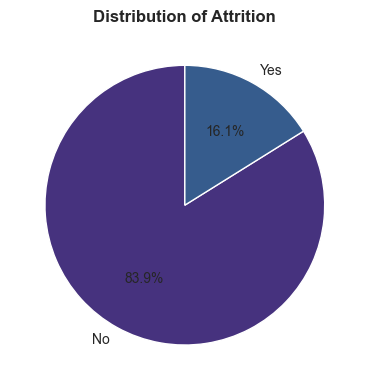

In [13]:
plot_pie(df, 'Attrition')

**Categorical Columns**

- Gender
- Department
- EducationField
- JobRole
- OverTime

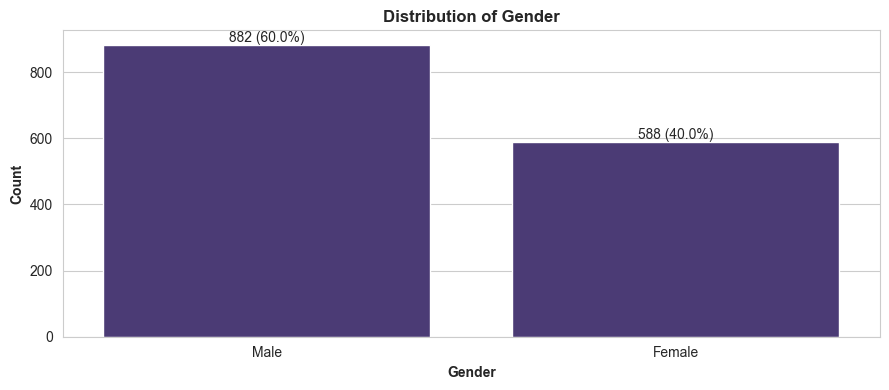

In [14]:
plot_countdist(df, 'Gender')

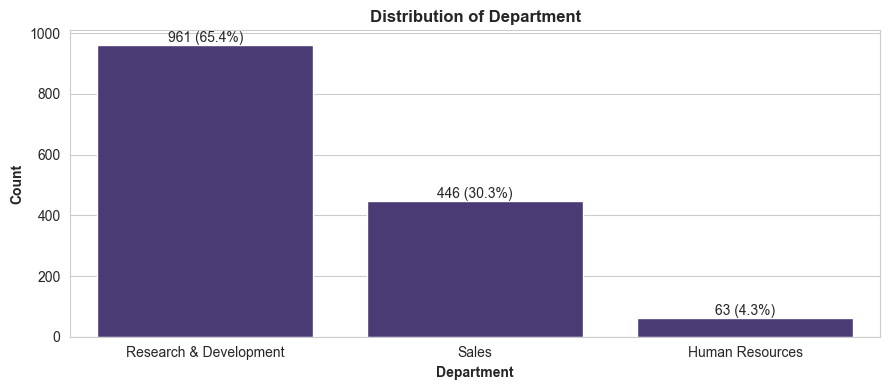

In [15]:
plot_countdist(df, 'Department')

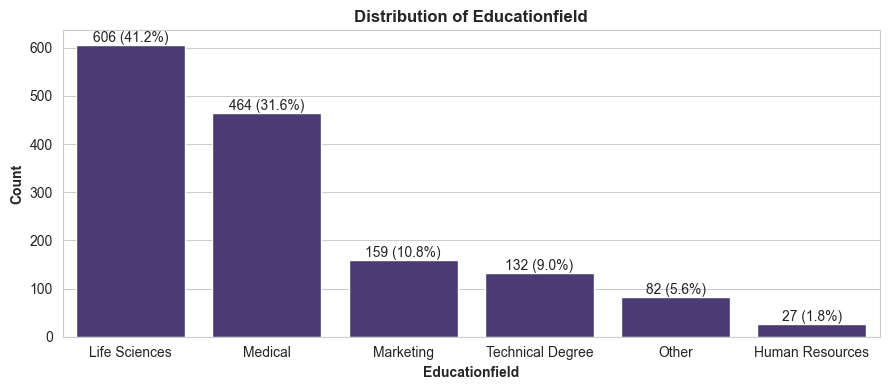

In [16]:
plot_countdist(df, 'EducationField')

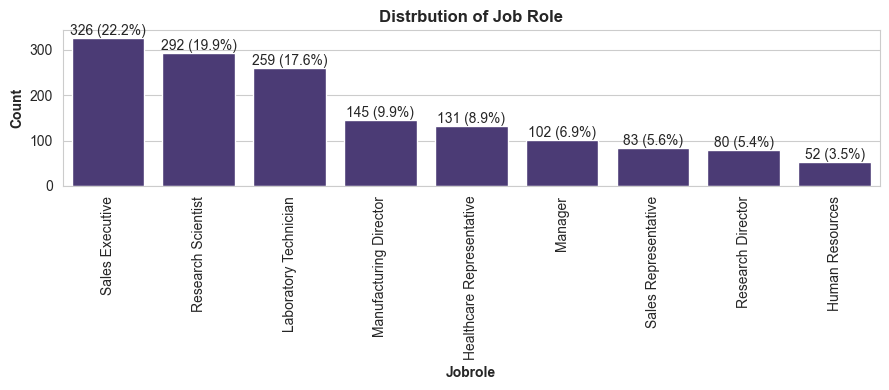

In [17]:
plot_countdist(df, 'JobRole', rotation=90, title='Distrbution of Job Role')

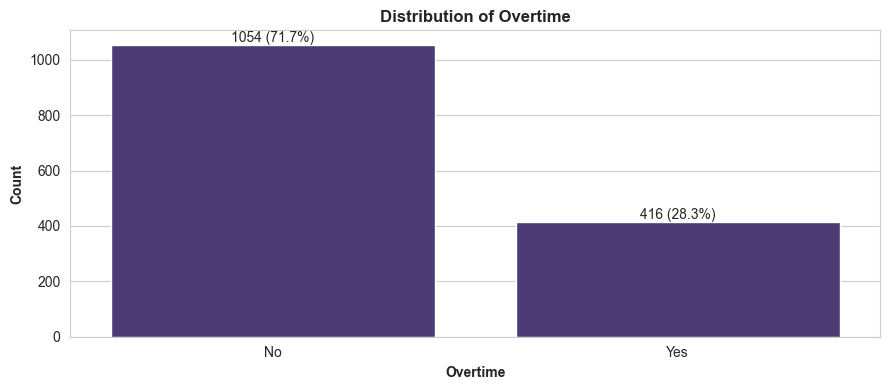

In [18]:
plot_countdist(df, 'OverTime')

**Numerical Columns**

- Age 
- DistanceFromHome
- Education
- EmployeeNumber
- EnvironmentSatisfaction
- HourlyRate
- JobInvolvement
- JobLevel
- JobSatisfaction
- MonthlyIncome
- MonthlyRate
- PerformanceRating
- TotalWorkingYears
- YearsAtCompany
- YearsInCurrentRole

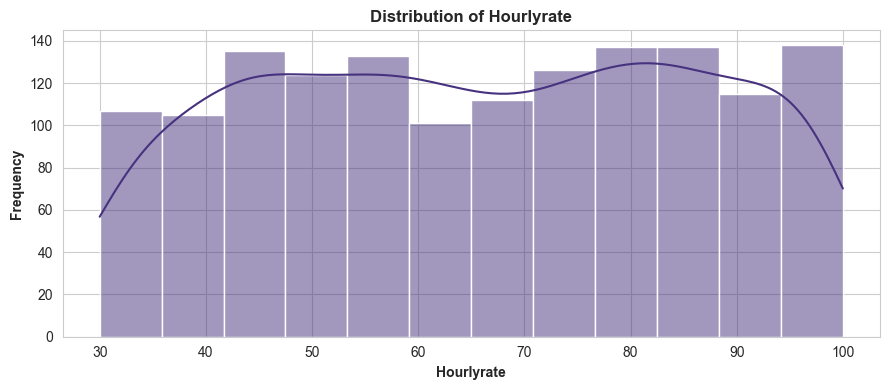

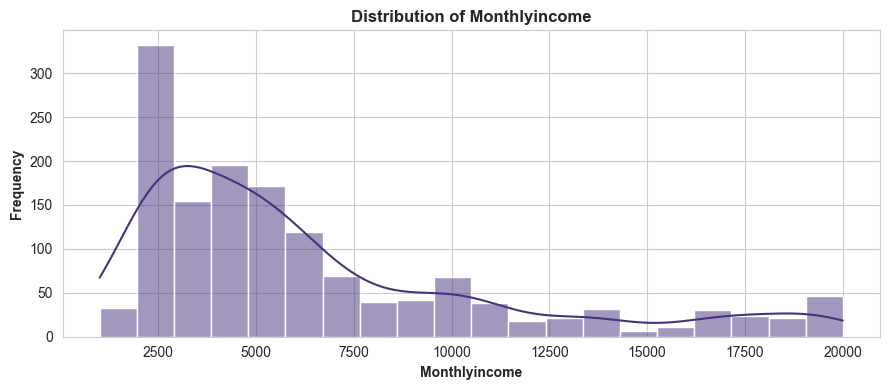

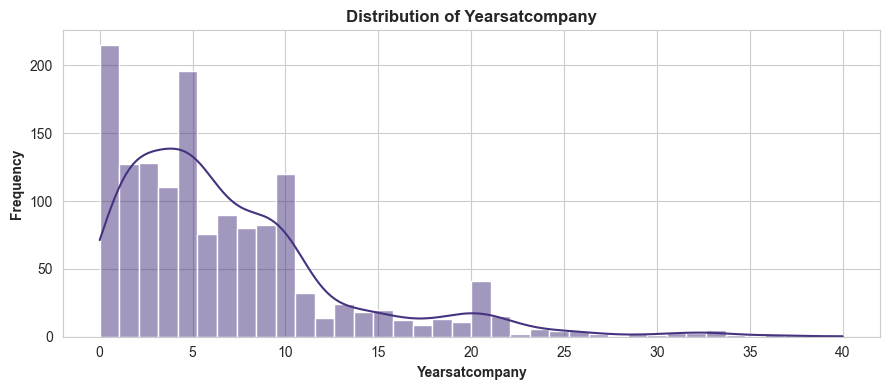

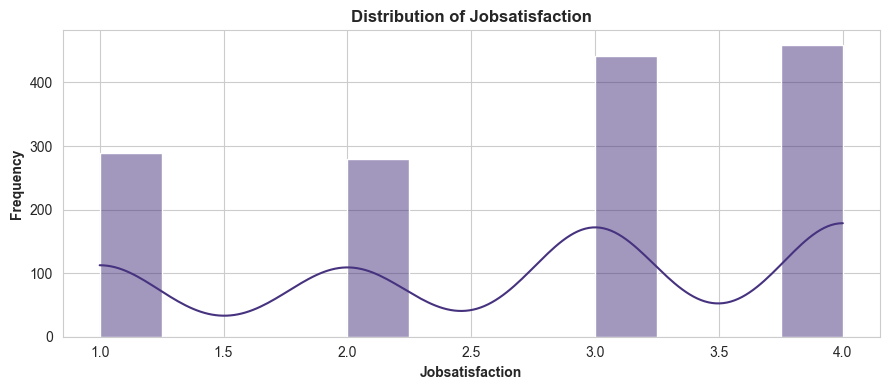

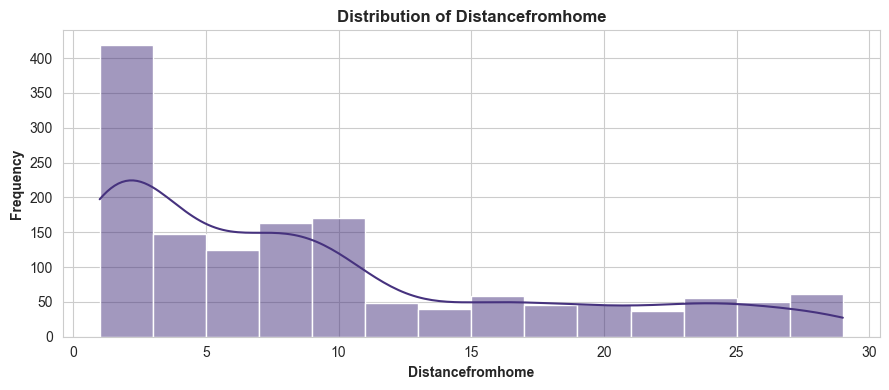

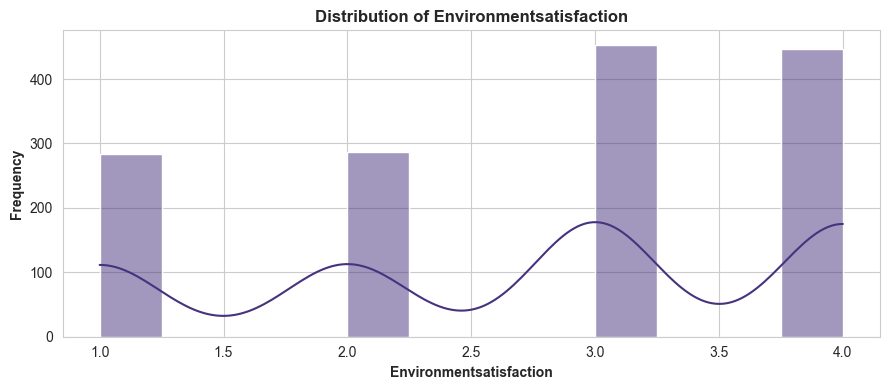

In [19]:
mask_numerical_cols = [
    'HourlyRate',
    'MonthlyIncome',
    'YearsAtCompany',
    'JobSatisfaction',
    'DistanceFromHome', 
    'EnvironmentSatisfaction',
]

for num_col in mask_numerical_cols:
    plot_histogram(df, num_col)

### Bivariate Analysis


**Categorical vs. Categorical Analysis**

- Gender vs. Attrition
- Gender vs. OverTime
- Department vs. JobRole
- OverTime vs. Department
- Department vs. Attrition

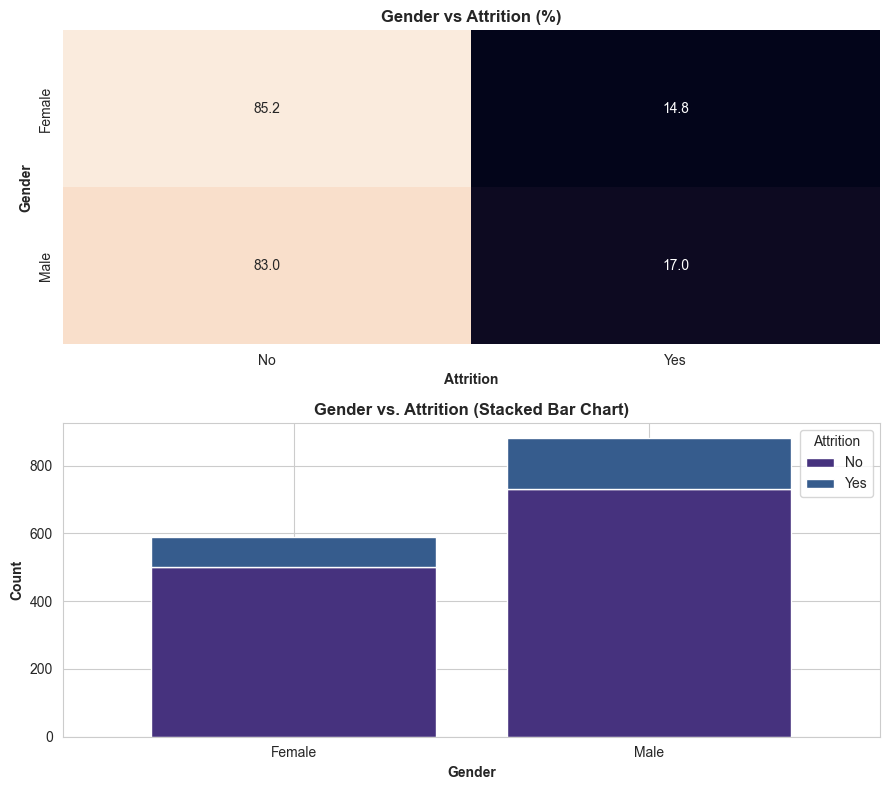

In [20]:
# Gender vs. Attrition
fig, axes = plt.subplots(2, 1, figsize=(9, 8))

gender_overtime = pd.crosstab(df['Gender'], df['Attrition'], normalize='index') * 100
sns.heatmap(gender_overtime, annot=True, fmt='.1f', cbar=False, ax=axes[0])
axes[0].set_title('Gender vs Attrition (%)')
axes[0].set_ylabel('Gender')
axes[0].set_xlabel('Attrition')

gender_attrition = pd.crosstab(df['Gender'], df['Attrition'])
gender_attrition.plot(kind='bar', stacked=True, width=0.8, ax=axes[1])
axes[1].set_title('Gender vs. Attrition (Stacked Bar Chart)')
axes[1].set_xlabel('Gender')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

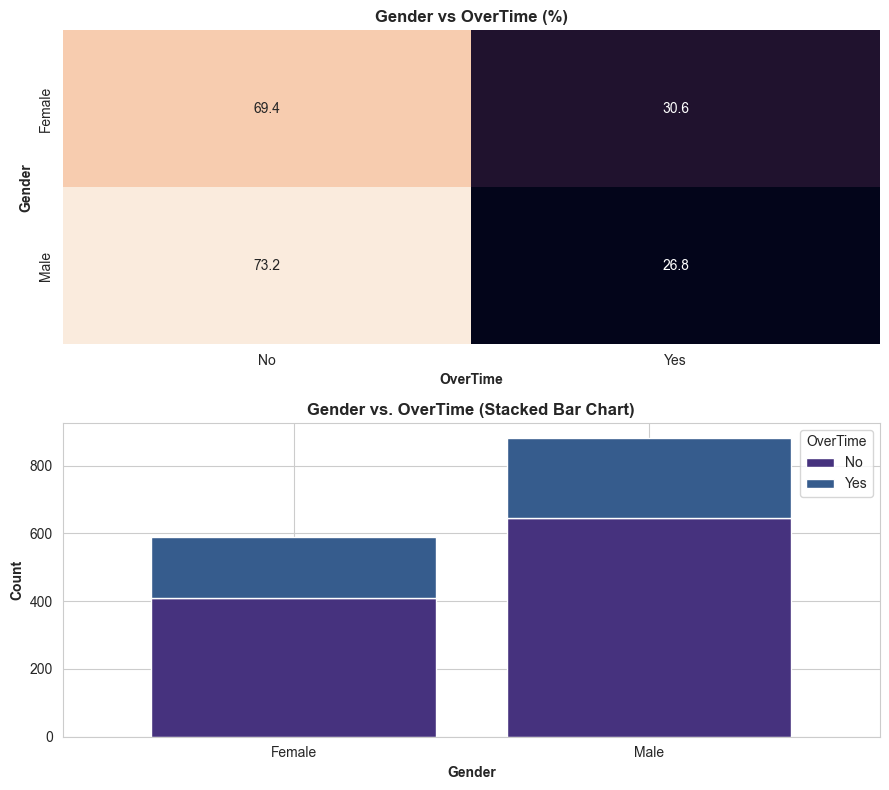

In [21]:
# Gender vs. OverTime
fig, axes = plt.subplots(2, 1, figsize=(9, 8))

gender_overtime = pd.crosstab(df['Gender'], df['OverTime'], normalize='index') * 100
sns.heatmap(gender_overtime, annot=True, fmt='.1f', cbar=False, ax=axes[0])
axes[0].set_title('Gender vs OverTime (%)')
axes[0].set_ylabel('Gender')
axes[0].set_xlabel('OverTime')

gender_attrition = pd.crosstab(df['Gender'], df['OverTime'])
gender_attrition.plot(kind='bar', stacked=True, width=0.8, ax=axes[1])
axes[1].set_title('Gender vs. OverTime (Stacked Bar Chart)')
axes[1].set_xlabel('Gender')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

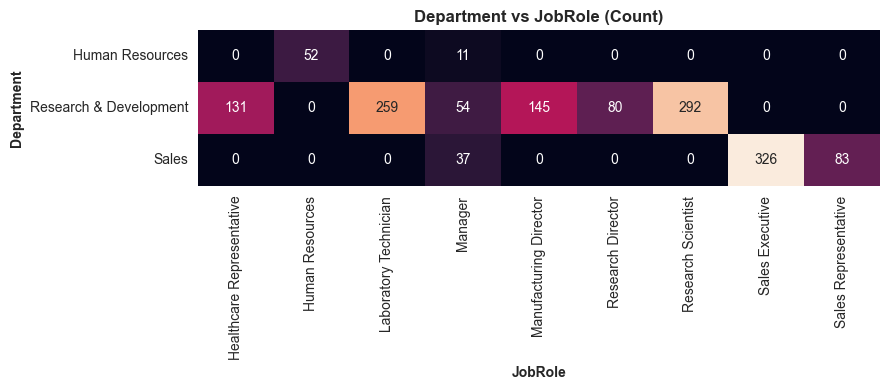

In [22]:
# Department vs JobRole
dept_jobrole = pd.crosstab(df['Department'], df['JobRole'])
sns.heatmap(dept_jobrole, annot=True, fmt='d', cbar=False)
plt.title('Department vs JobRole (Count)')
plt.ylabel('Department')
plt.xlabel('JobRole')
plt.tight_layout()
plt.show()

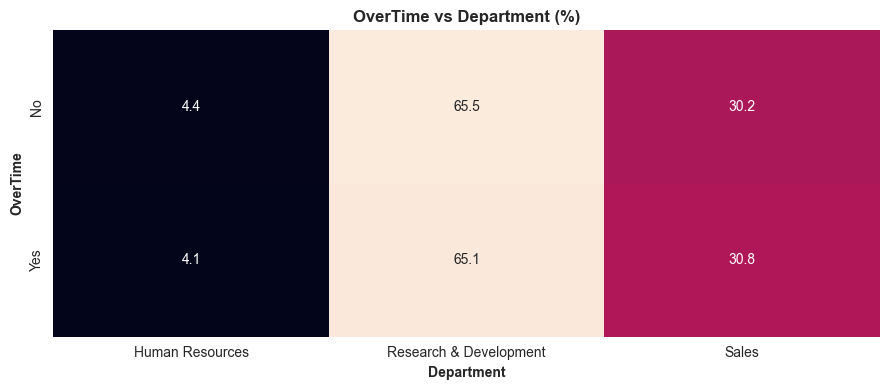

In [23]:
# OverTime vs Department
overtime_department = pd.crosstab(df['OverTime'], df['Department'], normalize='index') * 100
sns.heatmap(overtime_department, annot=True, fmt='.1f', cbar=False)
plt.title('OverTime vs Department (%)')
plt.ylabel('OverTime')
plt.xlabel('Department')
plt.tight_layout()
plt.show()

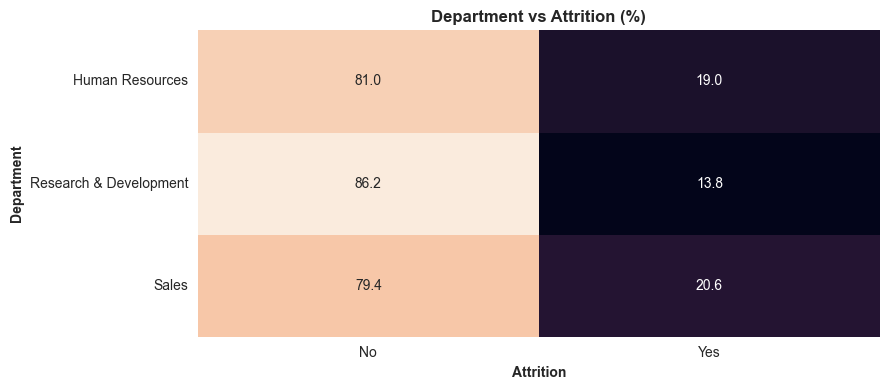

In [24]:
# Department vs. Attrition
department_attrition = pd.crosstab(df['Department'], df['Attrition'], normalize='index') * 100
sns.heatmap(department_attrition, annot=True, fmt='.1f', cbar=False)
plt.title('Department vs Attrition (%)')
plt.ylabel('Department')
plt.xlabel('Attrition')
plt.tight_layout()
plt.show()

**Categorical vs. Numerical Analysis**

- Gender vs. MonthlyIncome
- Department vs. YearsAtCompany
- OverTime vs. EnvironmentSatisfaction
- Department vs. MonthlyIncome
- EducationField vs. MonthlyIncome
- JobRole vs. MonthlyIncome

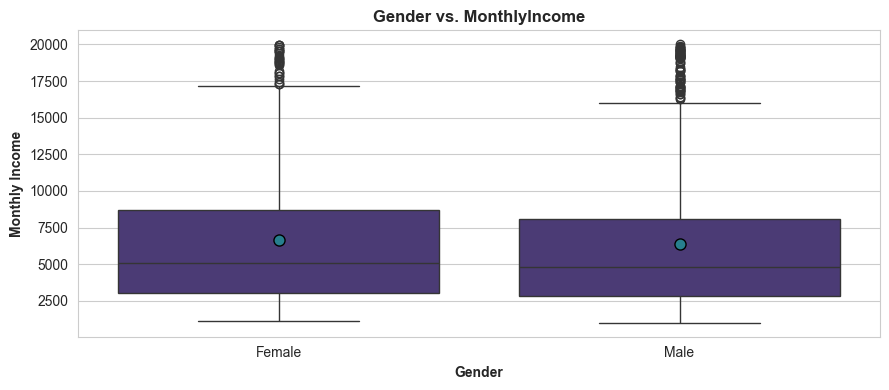

In [25]:
# Gender vs. MonthlyIncome
sns.boxplot(
    x='Gender', y='MonthlyIncome', data=df, showmeans=True, 
    meanprops={'marker': 'o', 'markeredgecolor': 'black', 'markersize': 8}
)
plt.title('Gender vs. MonthlyIncome')
plt.ylabel('Monthly Income')
plt.xlabel('Gender')
plt.tight_layout()
plt.show()

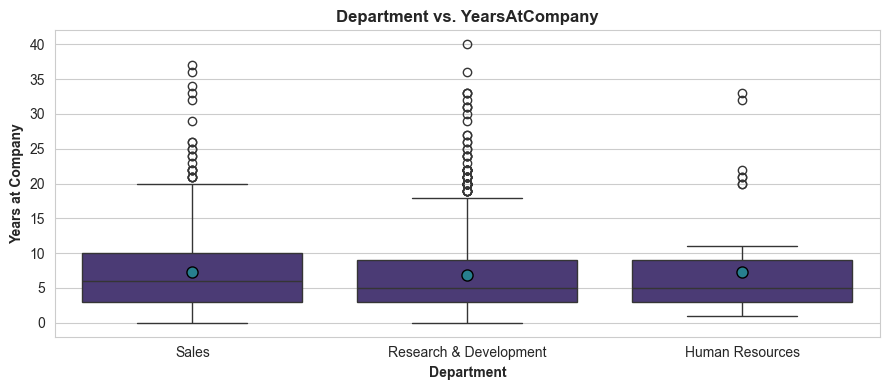

In [26]:
# Department vs. YearsAtCompany
sns.boxplot(
    x='Department', y='YearsAtCompany', data=df, showmeans=True, 
    meanprops={'marker': 'o', 'markeredgecolor': 'black', 'markersize': 8}
)
plt.title('Department vs. YearsAtCompany')
plt.ylabel('Years at Company')
plt.xlabel('Department')
plt.tight_layout()
plt.show()

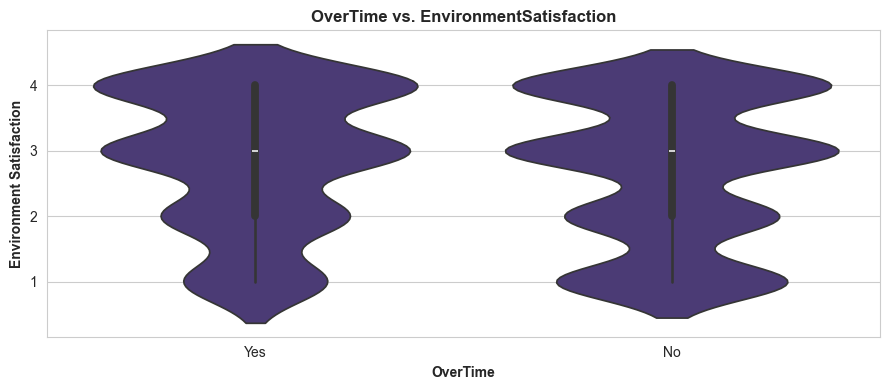

In [27]:
# OverTime vs. EnvironmentSatisfaction
sns.violinplot(x='OverTime', y='EnvironmentSatisfaction', data=df)
plt.title('OverTime vs. EnvironmentSatisfaction')
plt.ylabel('Environment Satisfaction')
plt.xlabel('OverTime')
plt.tight_layout()
plt.show()

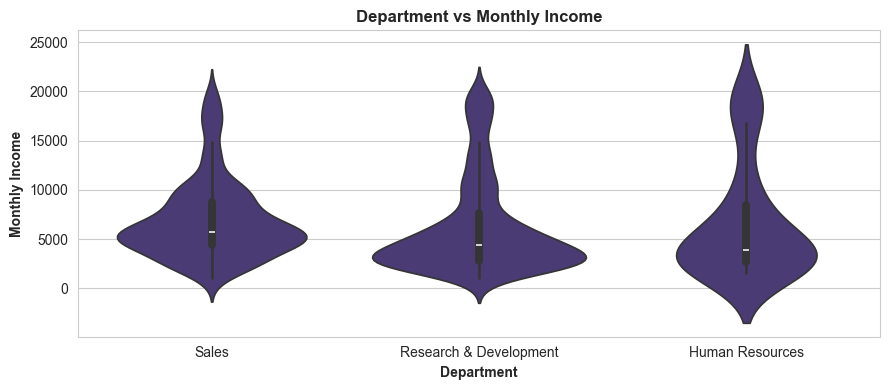

In [28]:
# Department vs. MonthlyIncome
sns.violinplot(x='Department', y='MonthlyIncome', data=df)
plt.title(f'Department vs Monthly Income')
plt.ylabel('Monthly Income')
plt.tight_layout()
plt.show()

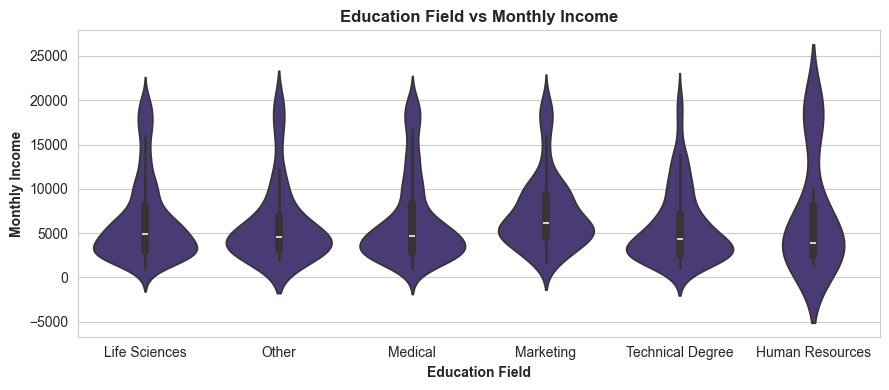

In [29]:
# EducationField vs. MonthlyIncome
sns.violinplot(x='EducationField', y='MonthlyIncome', data=df)
plt.title(f'Education Field vs Monthly Income')
plt.ylabel('Monthly Income')
plt.xlabel('Education Field')
plt.tight_layout()
plt.show()

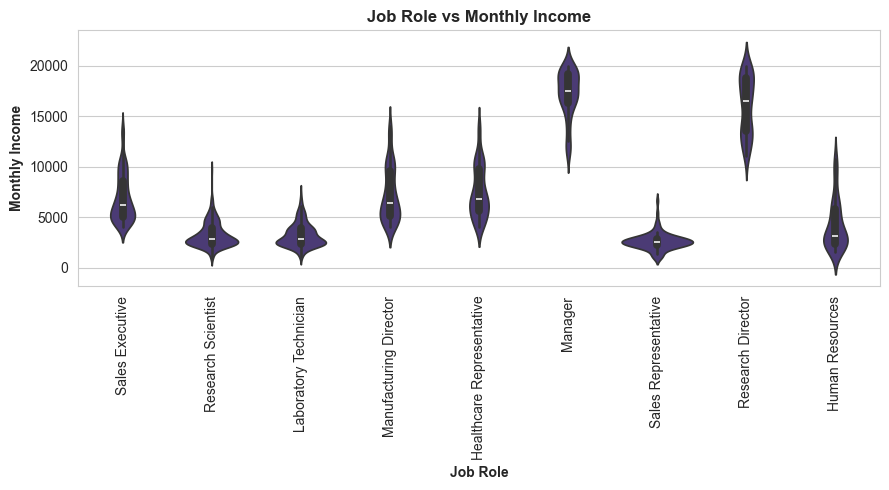

In [30]:
# JobRole vs. MonthlyIncome
plt.figure(figsize=(9, 5))
sns.violinplot(x='JobRole', y='MonthlyIncome', data=df)
plt.title(f'Job Role vs Monthly Income')
plt.ylabel('Monthly Income')
plt.xlabel('Job Role')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

**Numerical vs. Numerical Analysis**

- MonthlyIncome vs. YearsAtCompany
- MonthlyIncome vs. EnvironmentSatisfaction
- JobSatisfaction vs. EnvironmentSatisfaction

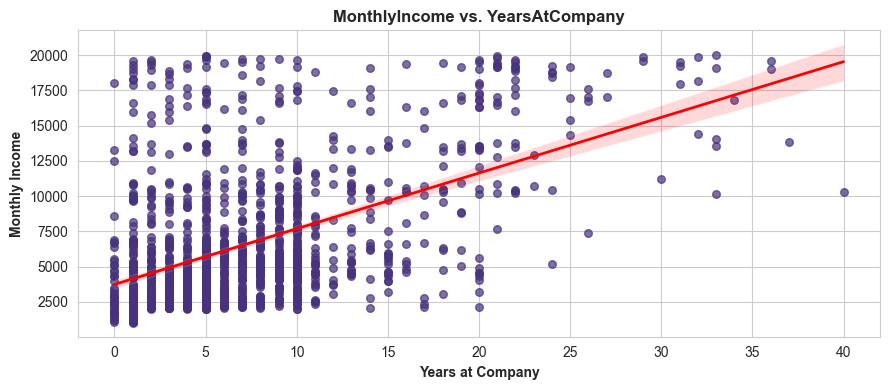

In [31]:
# MonthlyIncome vs. YearsAtCompany
sns.regplot(
    x='YearsAtCompany', y='MonthlyIncome', data=df, 
    scatter_kws={'s': 30, 'alpha': 0.7}, line_kws={'color': 'red', 'lw': 2}
)
plt.title('MonthlyIncome vs. YearsAtCompany')
plt.xlabel('Years at Company')
plt.ylabel('Monthly Income')
plt.tight_layout()
plt.show()

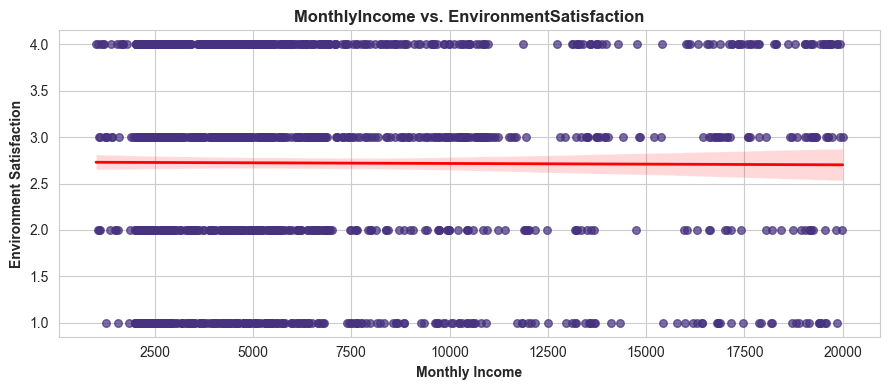

In [32]:
# MonthlyIncome vs. EnvironmentSatisfaction
sns.regplot(
    x='MonthlyIncome', y='EnvironmentSatisfaction', data=df, 
    scatter_kws={'s': 30, 'alpha': 0.7}, line_kws={'color': 'red', 'lw': 2}
)
plt.title('MonthlyIncome vs. EnvironmentSatisfaction')
plt.xlabel('Monthly Income')
plt.ylabel('Environment Satisfaction')
plt.tight_layout()
plt.show()

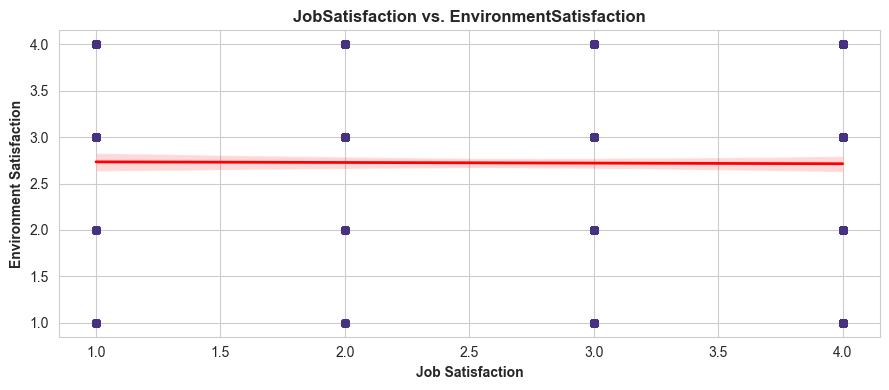

In [33]:
# JobSatisfaction vs. EnvironmentSatisfaction
sns.regplot(
    x='JobSatisfaction', y='EnvironmentSatisfaction', data=df, 
    scatter_kws={'s': 30, 'alpha': 0.7}, line_kws={'color': 'red', 'lw': 2}
)
plt.title('JobSatisfaction vs. EnvironmentSatisfaction')
plt.xlabel('Job Satisfaction')
plt.ylabel('Environment Satisfaction')
plt.tight_layout()
plt.show()

### Multivariate Analysis


**Cases**

- Gender vs. MonthlyIncome vs. Attrition
- Department vs. MonthlyIncome vs. Attrition
- OverTime vs. MonthlyIncome vs. Attrition
- OverTime vs. MonthlyIncome vs. Attrition vs. Gender vs. Department

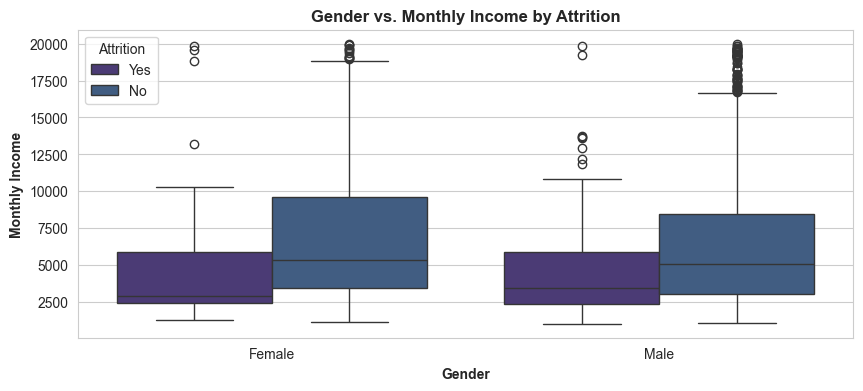

In [34]:
# Gender vs. MonthlyIncome vs. Attrition
plt.figure(figsize=(10, 4))
sns.boxplot(x='Gender', y='MonthlyIncome', hue='Attrition', data=df)
plt.title('Gender vs. Monthly Income by Attrition')
plt.ylabel('Monthly Income')
plt.show()

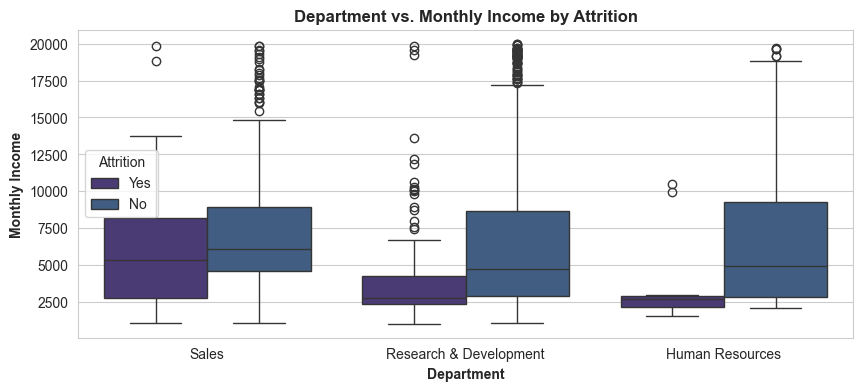

In [35]:
# Department vs. MonthlyIncome vs. Attrition
plt.figure(figsize=(10, 4))
sns.boxplot(x='Department', y='MonthlyIncome', hue='Attrition', data=df)
plt.title('Department vs. Monthly Income by Attrition')
plt.ylabel('Monthly Income')
plt.show()

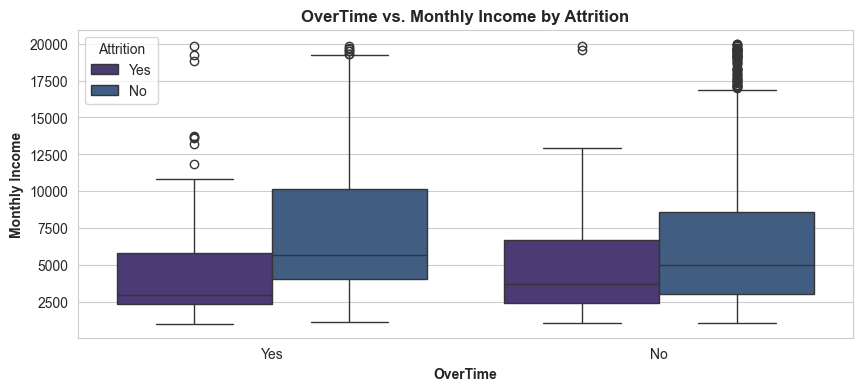

In [36]:
# OverTime vs. MonthlyIncome vs. Attrition
plt.figure(figsize=(10, 4))
sns.boxplot(x='OverTime', y='MonthlyIncome', hue='Attrition', data=df)
plt.title('OverTime vs. Monthly Income by Attrition')
plt.ylabel('Monthly Income')
plt.show()

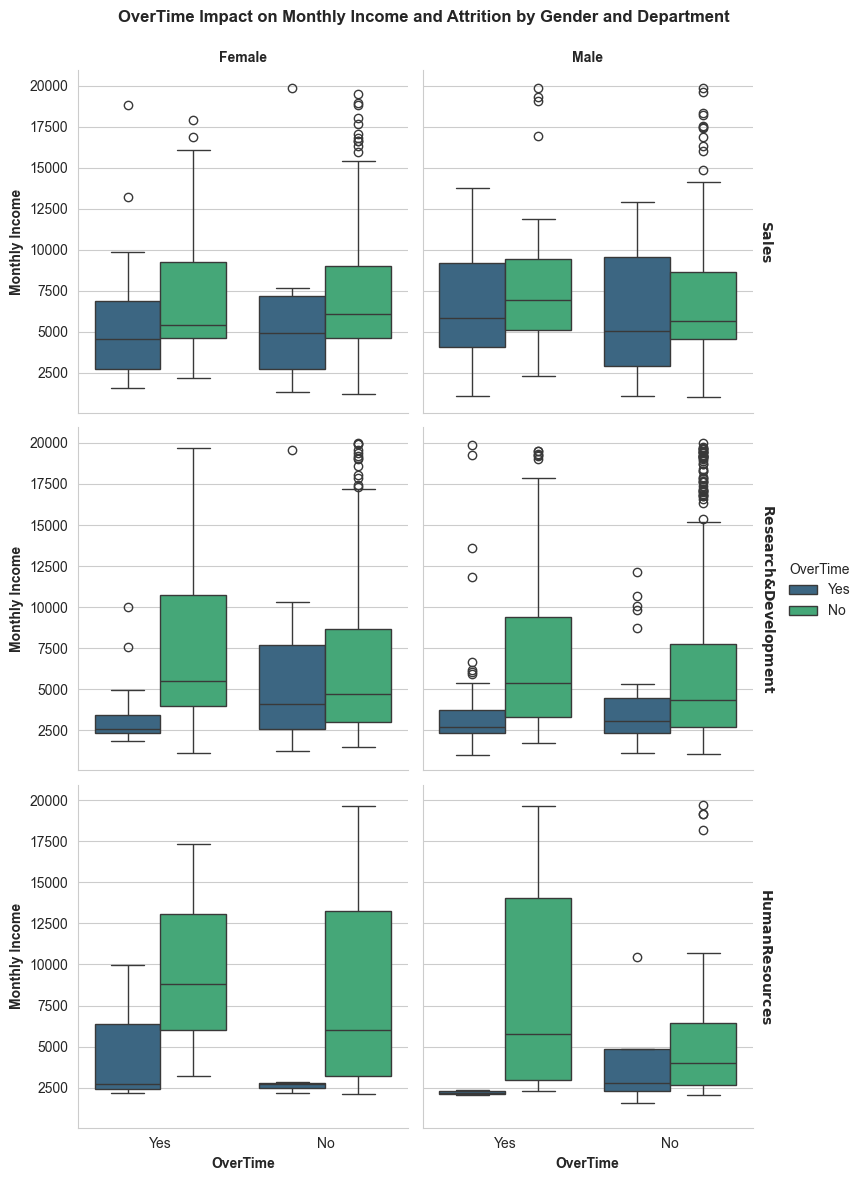

In [37]:
# OverTime vs. MonthlyIncome vs. Attrition vs. Gender vs. Department
g = sns.FacetGrid(
    df, col='Gender', row='Department', hue='OverTime', 
    margin_titles=True, height=4
)
g.map(
    sns.boxplot, 'OverTime', 'MonthlyIncome', 'Attrition', 
    order=['Yes', 'No'], hue_order=['Yes', 'No'], palette='viridis'
)

g.set_axis_labels('OverTime', 'Monthly Income')
g.set_titles(col_template='{col_name}', row_template=r'$\bf{{{row_name}}}$')
g.fig.suptitle('OverTime Impact on Monthly Income and Attrition by Gender and Department', fontweight='bold')
g.add_legend()
plt.subplots_adjust(top=0.93)
plt.show()

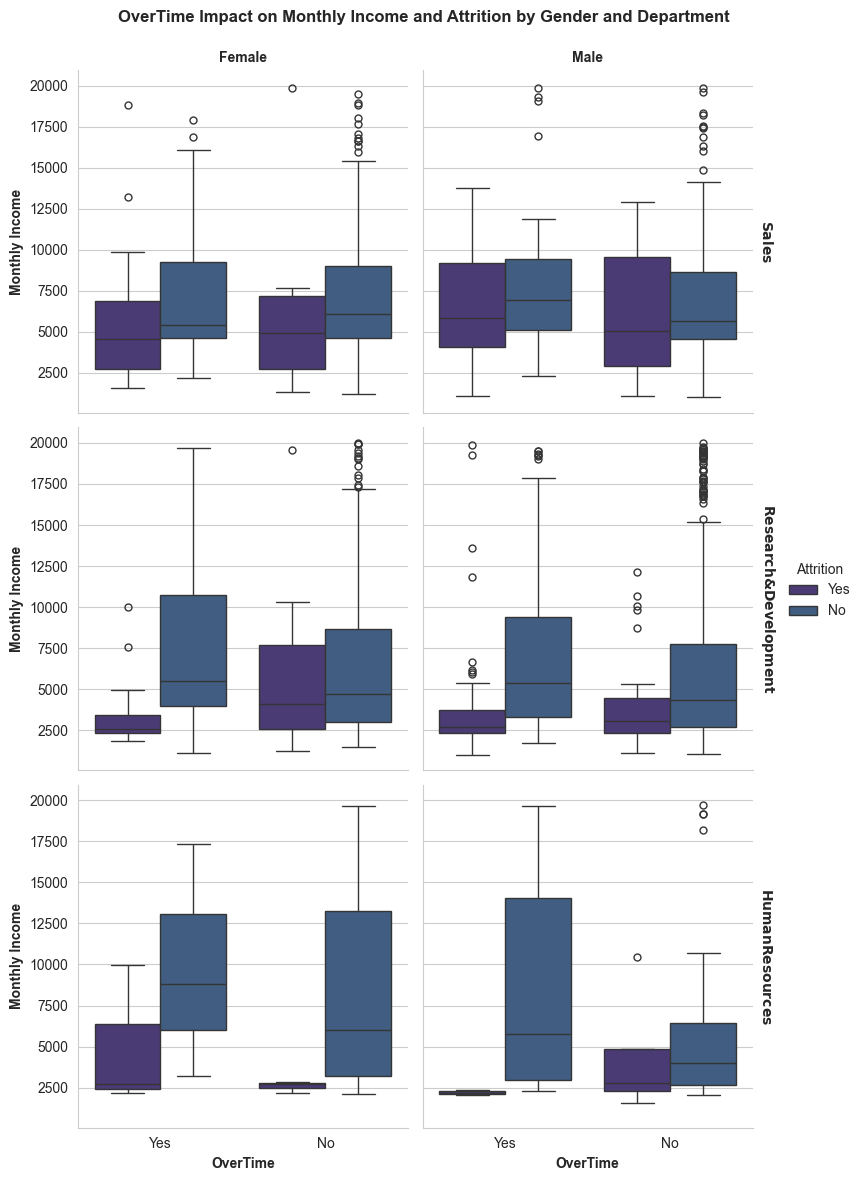

In [38]:
# OverTime vs. MonthlyIncome vs. Attrition vs. Gender vs. Department
cat_plot = sns.catplot(
    data=df, x='OverTime', y='MonthlyIncome',
    hue='Attrition', col='Gender', row='Department',
    kind='box', order=['Yes', 'No'], hue_order=['Yes', 'No'], 
    height=4, margin_titles=True,
)

cat_plot.set_axis_labels('OverTime', 'Monthly Income')
cat_plot.set_titles(col_template='{col_name}', row_template=r'$\bf{{{row_name}}}$')
cat_plot.fig.suptitle('OverTime Impact on Monthly Income and Attrition by Gender and Department', fontweight='bold')

plt.subplots_adjust(top=0.93)
plt.show()

**Correlation Heatmap**

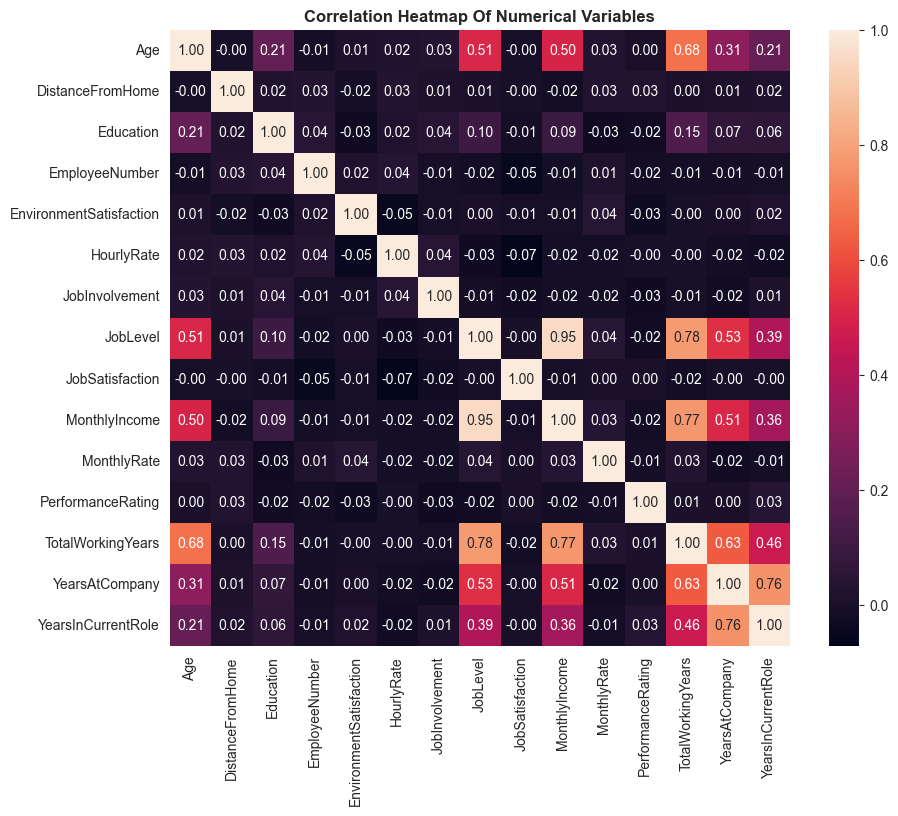

In [39]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f")
plt.title('Correlation Heatmap Of Numerical Variables')
plt.show()

**Pairwise Interaction**

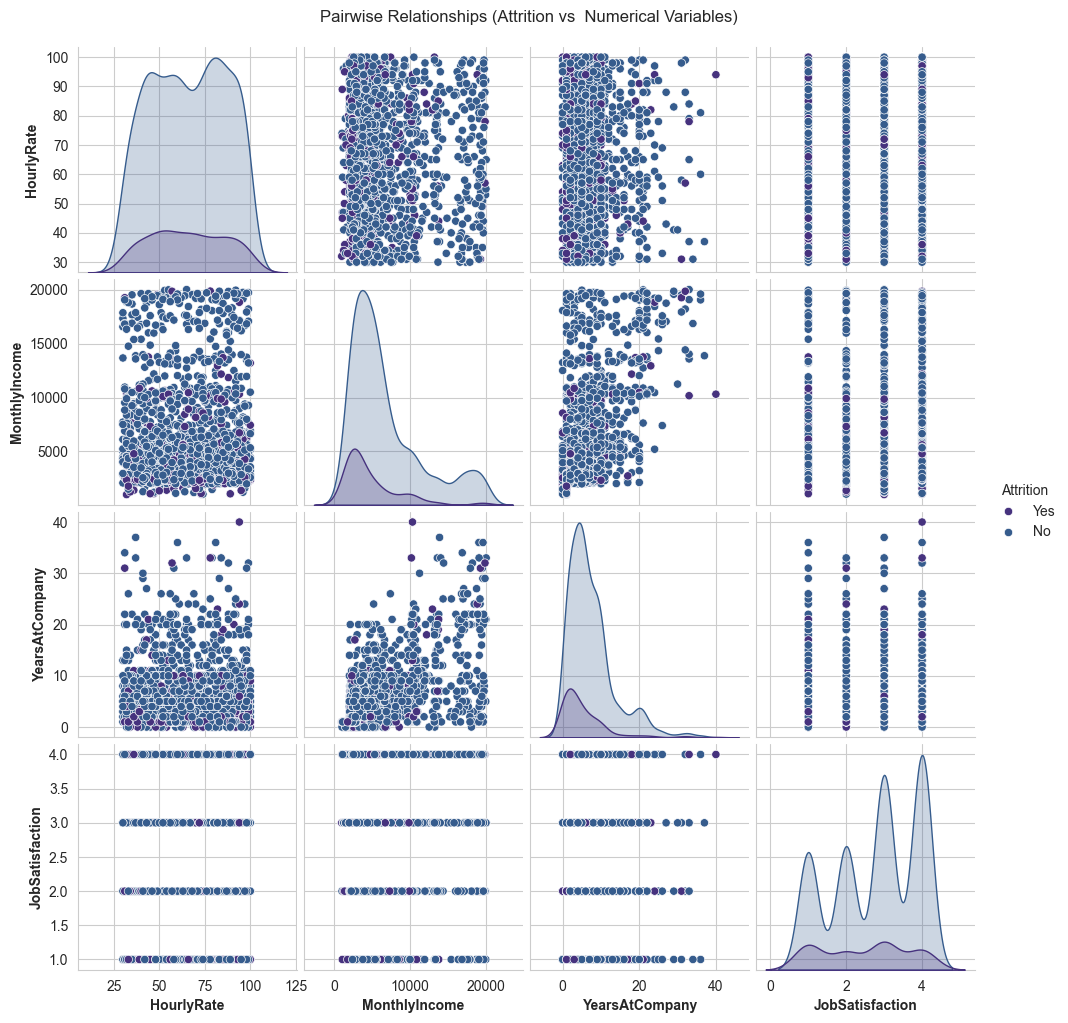

In [40]:
sns.pairplot(
    df, hue='Attrition', 
    vars=['HourlyRate', 'MonthlyIncome', 'YearsAtCompany', 'JobSatisfaction']
)
plt.suptitle('Pairwise Relationships (Attrition vs  Numerical Variables)', y=1.02)
plt.show()

**Q: How does the distance from home to work vary based on job role and whether employees leave or stay?**

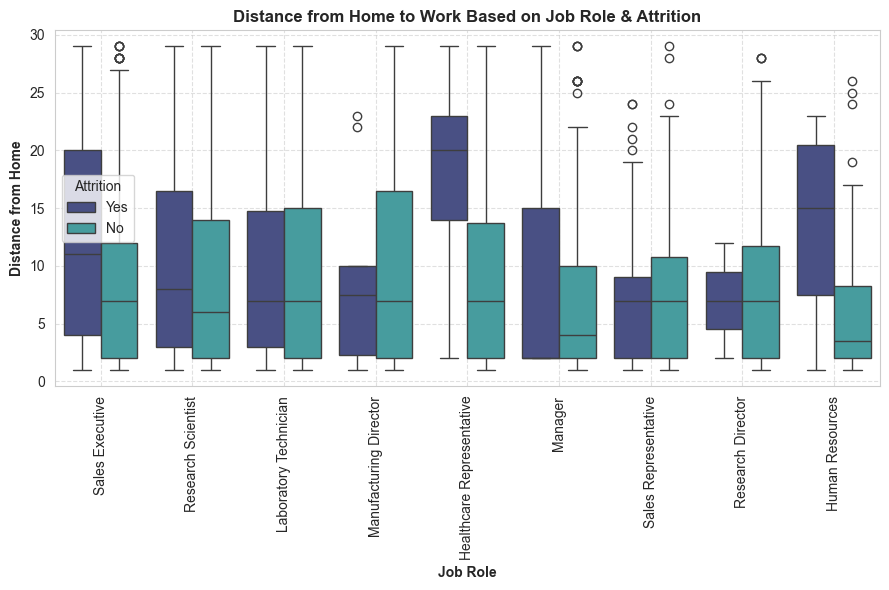

In [41]:
plt.figure(figsize=(9, 6))
sns.boxplot(data=df, x='JobRole', y='DistanceFromHome', hue='Attrition', fliersize=6, palette='mako')
plt.title('Distance from Home to Work Based on Job Role & Attrition')
plt.xlabel('Job Role')
plt.ylabel('Distance from Home')
plt.grid(True, linestyle='--',alpha=0.6)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('../plots/BoxPlotV_Q1.png')
plt.show()

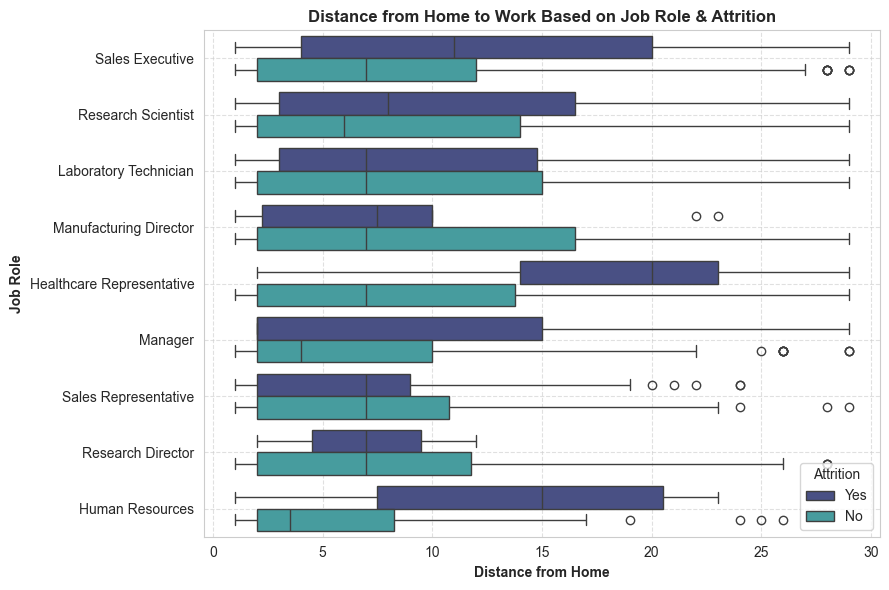

In [42]:
plt.figure(figsize=(9, 6))
sns.boxplot(data=df, y='JobRole', x='DistanceFromHome', hue='Attrition', fliersize=6, palette='mako')
plt.title('Distance from Home to Work Based on Job Role & Attrition')
plt.xlabel('Distance from Home')
plt.ylabel('Job Role')
plt.grid(True, linestyle='--',alpha=0.6)
plt.tight_layout()
plt.savefig('../plots/BoxPlotH_Q1.png')
plt.show()

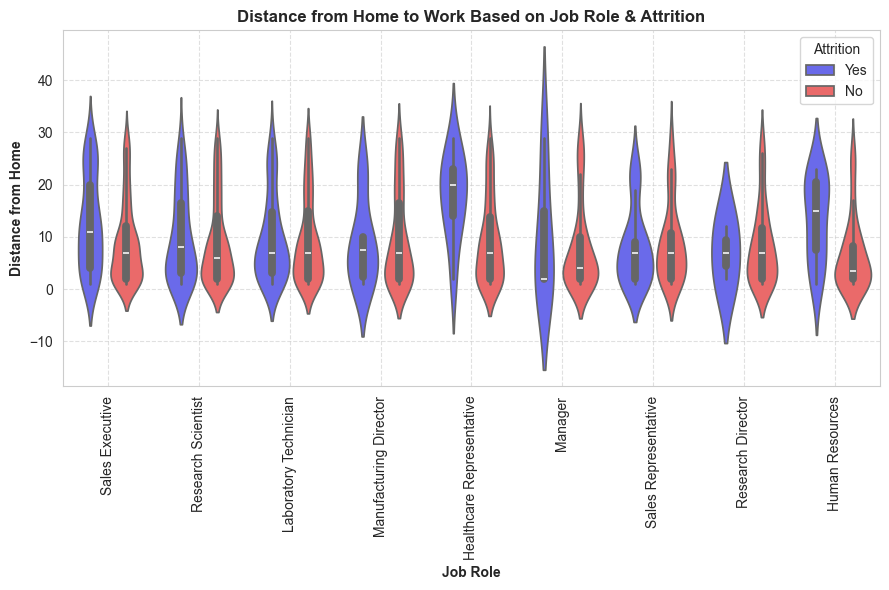

In [43]:
plt.figure(figsize=(9, 6))
sns.violinplot(data=df, x='JobRole', y='DistanceFromHome', hue='Attrition', palette='seismic')
plt.title('Distance from Home to Work Based on Job Role & Attrition')
plt.xlabel('Job Role')
plt.ylabel('Distance from Home')
plt.grid(True, linestyle='--',alpha=0.6)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('../plots/ViolinPlotV_Q1.png')
plt.show()

**Q: How do education and monthly income affect the likelihood of an employee leaving?**

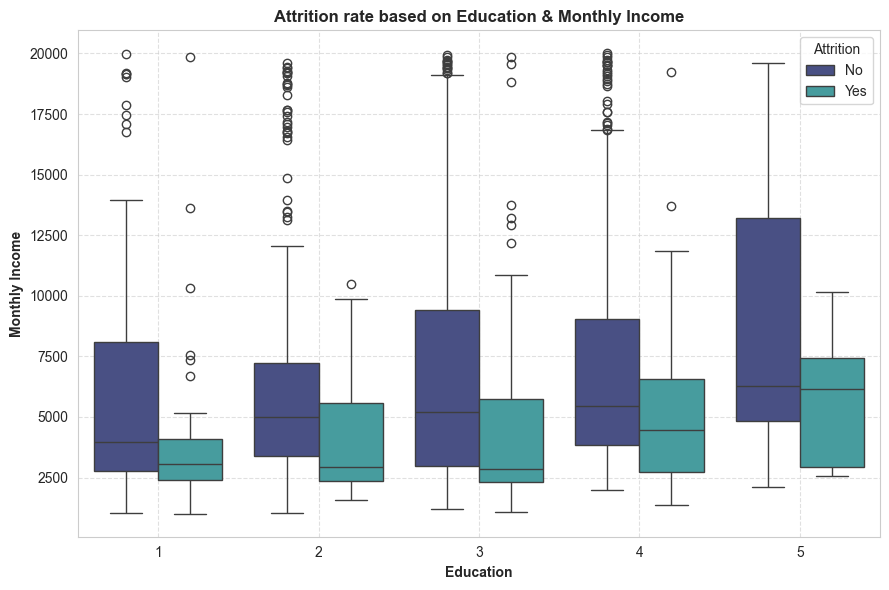

In [44]:
plt.figure(figsize=(9, 6))
sns.boxplot(data=df, x='Education', y='MonthlyIncome', hue='Attrition', fliersize=6, palette='mako')
plt.title('Attrition rate based on Education & Monthly Income')
plt.xlabel('Education')
plt.ylabel('Monthly Income')
plt.grid(True, linestyle='--',alpha=0.6)
plt.tight_layout()
plt.savefig('../plots/BoxPlotV_Q2.png')
plt.show()

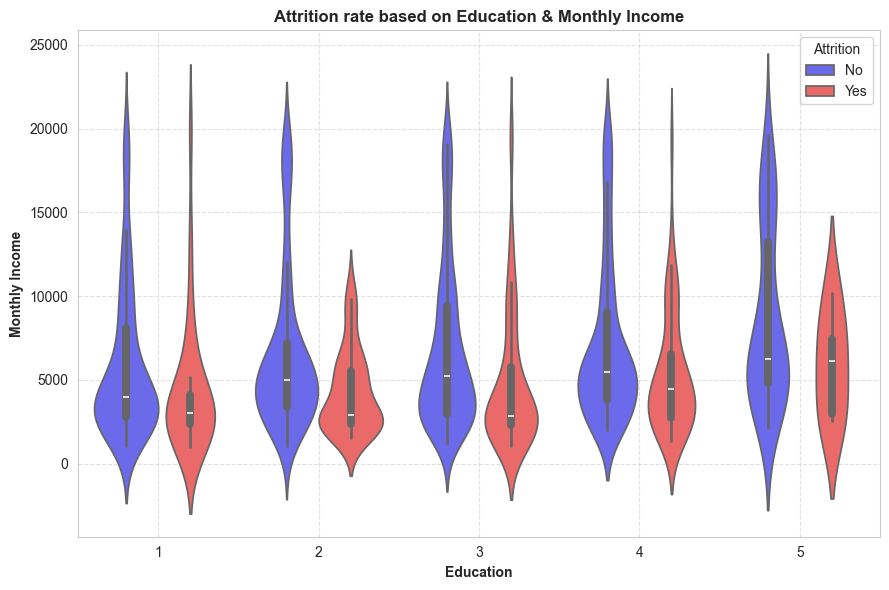

In [45]:
plt.figure(figsize=(9, 6))
sns.violinplot(data=df, x='Education', y='MonthlyIncome', hue='Attrition', palette='seismic')
plt.title('Attrition rate based on Education & Monthly Income')
plt.xlabel('Education')
plt.ylabel('Monthly Income')
plt.grid(True, linestyle='--',alpha=0.6)
plt.tight_layout()
plt.savefig('../plots/ViolinPlotV_Q2.png')
plt.show()

### Statistical Testing

- Categorical Variables Test
- Numerical Variables Test
- Categorical & Numerical Variables Test

**Categorical Variables Test**

- `Chi-Square Test Of Independence`: Test the association between each categorical variable and the target variable Attrition.
    - Null Hypothesis (H0): No association between categorical variable and Attrition.
    - Alternative Hypothesis (H1): There is an association between the categorical variable and Attrition.

In [46]:
categorical_vars = ['Gender', 'Department', 'EducationField', 'JobRole', 'OverTime']

SIGNIFICANCE_LEVEL = 0.05

for var in categorical_vars:
    contingency_table = pd.crosstab(df[var], df['Attrition'])
    chi2, p, _, _ = chi2_contingency(contingency_table)

    print(f'\nVariable: {var}')
    print(f'P-Value: {round(p, 4)}')
    print(f'Chi-Square Statistic: {round(chi2, 4)}')
    
    if p <= SIGNIFICANCE_LEVEL:
        print('Result: Reject the null hypothesis.')
        print(f'Conclusion: There is a statistically significant association between {var} and Attrition.')
    else:
        print('Result: Fail to reject the null hypothesis.')
        print(f'Conclusion: There is no statistically significant association between {var} and Attrition.')


Variable: Gender
P-Value: 0.2906
Chi-Square Statistic: 1.117
Result: Fail to reject the null hypothesis.
Conclusion: There is no statistically significant association between Gender and Attrition.

Variable: Department
P-Value: 0.0045
Chi-Square Statistic: 10.796
Result: Reject the null hypothesis.
Conclusion: There is a statistically significant association between Department and Attrition.

Variable: EducationField
P-Value: 0.0068
Chi-Square Statistic: 16.0247
Result: Reject the null hypothesis.
Conclusion: There is a statistically significant association between EducationField and Attrition.

Variable: JobRole
P-Value: 0.0
Chi-Square Statistic: 86.1903
Result: Reject the null hypothesis.
Conclusion: There is a statistically significant association between JobRole and Attrition.

Variable: OverTime
P-Value: 0.0
Chi-Square Statistic: 87.5643
Result: Reject the null hypothesis.
Conclusion: There is a statistically significant association between OverTime and Attrition.


**Numerical Variables Test**

- `T-test`: If the numerical variables are normally distributed.
- `Mann-Whitney U test`: If the numerical variables are not normally distributed.
- `Shapiro-Wilk test`: To check the if numerical variables are normally distributed or not.

In [47]:
numerical_vars = [
    'HourlyRate', 'MonthlyIncome', 'YearsAtCompany', 'JobSatisfaction', 'DistanceFromHome', 'EnvironmentSatisfaction'
]

normality_results = {}
print('Normality Test Results (Shapiro-Wilk):')

for var in numerical_vars:
    stat, p = shapiro(df[var])

    normality = 'Normal' if p > 0.05 else 'Skewed'
    normality_results[var] = {'P-Value': p, 'Distribution': normality}
    print(f'\n{var}:\nP-Value = {p} ({normality})')

Normality Test Results (Shapiro-Wilk):

HourlyRate:
P-Value = 7.418846333333586e-21 (Skewed)

MonthlyIncome:
P-Value = 4.402394036501214e-37 (Skewed)

YearsAtCompany:
P-Value = 3.6688670459822384e-36 (Skewed)

JobSatisfaction:
P-Value = 1.3734335097160986e-35 (Skewed)

DistanceFromHome:
P-Value = 4.080847148972682e-34 (Skewed)

EnvironmentSatisfaction:
P-Value = 2.7378881881962794e-35 (Skewed)


In [48]:
test_results = {}

for var in numerical_vars:
    attrition_yes = df[df['Attrition'] == 'Yes'][var]
    attrition_no = df[df['Attrition'] == 'No'][var]

    if normality_results[var]['Distribution'] == 'Normal':
        stat, p = ttest_ind(attrition_yes, attrition_no, equal_var=False)
        test_type = 'Independent T-Test'
    else:
        stat, p = mannwhitneyu(attrition_yes, attrition_no)
        test_type = 'Mann-Whitney U Test'
    
    significance = 'Significant' if p <= 0.05 else 'Not Significant'
    
    test_results[var] = {
        'Test': test_type,
        'Statistic': stat,
        'P-Value': p,
        'Significance': significance
    }

In [49]:
summary = {}

for var in numerical_vars:
    summary[var] = {
        'Distribution': normality_results[var]['Distribution'],
        'Test': test_results[var]['Test'],
        'P-Value': test_results[var]['P-Value'],
        'Significance': test_results[var]['Significance']
    }

print('Numerical Variables Test Results:')

for var, results in summary.items():
    print(f'\n{var}:')
    print(f'Distribution: {results["Distribution"]}')
    print(f'Test Used: {results["Test"]}')
    print(f'p-value: {results["P-Value"]}')
    print(f'Significance: {results["Significance"]}')


Numerical Variables Test Results:

HourlyRate:
Distribution: Skewed
Test Used: Mann-Whitney U Test
p-value: 0.7976302912394753
Significance: Not Significant

MonthlyIncome:
Distribution: Skewed
Test Used: Mann-Whitney U Test
p-value: 2.950830917288873e-14
Significance: Significant

YearsAtCompany:
Distribution: Skewed
Test Used: Mann-Whitney U Test
p-value: 2.916191369956416e-13
Significance: Significant

JobSatisfaction:
Distribution: Skewed
Test Used: Mann-Whitney U Test
p-value: 7.95791784089101e-05
Significance: Significant

DistanceFromHome:
Distribution: Skewed
Test Used: Mann-Whitney U Test
p-value: 0.0023870470273627984
Significance: Significant

EnvironmentSatisfaction:
Distribution: Skewed
Test Used: Mann-Whitney U Test
p-value: 0.00021730490274301747
Significance: Significant


**Categorical & Numerical Variables Test**

- `ANOVA (Analysis of Variance)`: When the numerical variable is normally distributed for each category of the categorical variable.
- `Kruskal-Wallis H Test`: When the numerical variable is not normally distributed or the group variances are unequal.

In [50]:
categorical_vars = [
    'Gender', 'Department', 'EducationField', 'JobRole', 'OverTime'
]
numerical_vars = [
    'HourlyRate', 'MonthlyIncome', 'YearsAtCompany', 
    'JobSatisfaction', 'DistanceFromHome', 'EnvironmentSatisfaction'
]

In [51]:

normality_results = {}

for cat_var in categorical_vars:
    for num_var in numerical_vars:
        key = f'{cat_var} vs {num_var}'
        normality_results[key] = {}

        for category in df[cat_var].unique():
            subset = df[df[cat_var] == category][num_var]
            stat, p = shapiro(subset)
            distribution = 'Normal' if p > 0.05 else 'Skewed'
            normality_results[key][category] = {'p-value': p, 'Distribution': distribution}


In [52]:
test_results = {}

for cat_var in categorical_vars:
    for num_var in numerical_vars:
        key = f'{cat_var} vs {num_var}'
        groups = [df[df[cat_var] == category][num_var] for category in df[cat_var].unique()]

        is_all_normal = all(
            normality_results[key][cat]['Distribution'] == 'Normal' 
            for cat in df[cat_var].unique()
        )
        if is_all_normal:
            stat, p = f_oneway(*groups)
            test_type = 'ANOVA'
        else:
            stat, p = kruskal(*groups)
            test_type = 'Kruskal-Wallis'
        
        test_results[key] = {
            'Test': test_type,
            'Statistic': round(stat, 4),
            'p-value': round(p, 4),
            'Significance': 'Significant' if p <= 0.05 else 'Not Significant'
        }

In [53]:
print('Significant Results (Categorical vs Numerical):')

for key, res in test_results.items():
    if res['Significance'] == 'Significant':
        print(f'\n{key}')
        print(f'Test: {res["Test"]}')
        print(f'P-value: {res["p-value"]}')
        print(f'Statistic: {res["Statistic"]}')

Significant Results (Categorical vs Numerical):

Department vs MonthlyIncome
Test: Kruskal-Wallis
P-value: 0.0
Statistic: 42.6186

EducationField vs MonthlyIncome
Test: Kruskal-Wallis
P-value: 0.0002
Statistic: 24.7915

JobRole vs MonthlyIncome
Test: Kruskal-Wallis
P-value: 0.0
Statistic: 1073.4101

JobRole vs YearsAtCompany
Test: Kruskal-Wallis
P-value: 0.0
Statistic: 222.9854

OverTime vs EnvironmentSatisfaction
Test: Kruskal-Wallis
P-value: 0.0095
Statistic: 6.727


## Feature Engineering & ML

In [54]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score

from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, ExtraTreesClassifier

In [55]:
df.head()

,Attrition,Gender,Department,EducationField,JobRole,OverTime,Age,DistanceFromHome,Education,EmployeeNumber,...,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,PerformanceRating,TotalWorkingYears,YearsAtCompany,YearsInCurrentRole
0,Yes,Female,Sales,Life Sciences,Sales Executive,Yes,41,1,2,1,...,94,3,2,4,5993,19479,3,8,6,4
1,No,Male,Research & Development,Life Sciences,Research Scientist,No,49,8,1,2,...,61,2,2,2,5130,24907,4,10,10,7
2,Yes,Male,Research & Development,Other,Laboratory Technician,Yes,37,2,2,4,...,92,2,1,3,2090,2396,3,7,0,0
3,No,Female,Research & Development,Life Sciences,Research Scientist,Yes,33,3,4,5,...,56,3,1,3,2909,23159,3,8,8,7
4,No,Male,Research & Development,Medical,Laboratory Technician,No,27,2,1,7,...,40,3,1,2,3468,16632,3,6,2,2


In [56]:
X = df.drop('Attrition', axis=1)
y = df['Attrition'].map({'Yes': 1, 'No': 0})

In [57]:
y.head()

0    1
1    0
2    1
3    0
4    0
Name: Attrition, dtype: int64

In [58]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [59]:
print(f'X-train Shape: {X_train.shape}')
print(f'Y-train Shape: {y_train.shape}')
print(f'X-test Shape: {X_test.shape}')
print(f'Y-test Shape: {y_test.shape}')

X-train Shape: (1176, 20)
Y-train Shape: (1176,)
X-test Shape: (294, 20)
Y-test Shape: (294,)


In [60]:
df.iloc[:, 1:6].columns.to_list()

['Gender', 'Department', 'EducationField', 'JobRole', 'OverTime']

In [61]:
df.iloc[:, 6:].columns.to_list()

['Age',
 'DistanceFromHome',
 'Education',
 'EmployeeNumber',
 'EnvironmentSatisfaction',
 'HourlyRate',
 'JobInvolvement',
 'JobLevel',
 'JobSatisfaction',
 'MonthlyIncome',
 'MonthlyRate',
 'PerformanceRating',
 'TotalWorkingYears',
 'YearsAtCompany',
 'YearsInCurrentRole']

In [62]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), df.iloc[:, 6:].columns.to_list()),
        ('cat', OneHotEncoder(handle_unknown='ignore'), df.iloc[:, 1:6].columns.to_list()),
    ]
)

In [63]:
pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42)),
    ]
)

In [64]:
param_grid = {
    'classifier__n_estimators': [100, 200, 500],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 5],
}


In [65]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'DistanceFromHome',
                                                                          'Education',
                                                                          'EmployeeNumber',
                                                                          'EnvironmentSatisfaction',
                                                                          'HourlyRate',
                                                                          'JobInvolvement',
                                                                          'JobLevel',
                                                                          'JobSatisfaction',
                                                                          'MonthlyIncome',
                                                                          'MonthlyRate',
                                                                          'PerformanceRating',
                                                                          'TotalWorkingYears',
                                                                          'YearsAtCompany',
                                                                          'YearsI...
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Gender',
                                                                          'Department',
                                                                          'EducationField',
                                                                          'JobRole',
                                                                          'OverTime'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [10, 20, None],
                         'classifier__min_samples_leaf': [1, 2, 5],
                         'classifier__min_samples_split': [2, 5, 10],
                         'classifier__n_estimators': [100, 200, 500]},
             scoring='roc_auc')

In [66]:
best_model = grid_search.best_estimator_
print('Best Parameters:', grid_search.best_params_)

Best Parameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}


In [67]:
y_pred = best_model.predict(X_test)
y_pred_prob = best_model.predict_proba(X_test)[:, 1]

In [68]:
print('Accuracy:', accuracy_score(y_test, y_pred))
print('ROC-AUC:', roc_auc_score(y_test, y_pred_prob))

Accuracy: 0.8401360544217688
ROC-AUC: 0.7646653458523559


In [69]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91       247
           1       0.50      0.19      0.28        47

    accuracy                           0.84       294
   macro avg       0.68      0.58      0.59       294
weighted avg       0.80      0.84      0.81       294



In [70]:
pickle.dump(best_model, open('../models/RandomForest.pkl', 'wb'))

In [71]:
cat_features = best_model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(
    df.iloc[:, 1:6].columns.to_list()
)
features = np.concatenate([df.iloc[:, 6:].columns.to_list(), cat_features])

In [72]:
importances = best_model.named_steps['classifier'].feature_importances_
importance_df = pd.DataFrame({'feature': features, 'importance': importances})


In [73]:
importance_df['feature'] = importance_df['feature'].str.split('_').str[0]
aggregated_importances = (
    importance_df.groupby('feature')['importance']
    .sum()
    .sort_values(ascending=False)
)

In [74]:
importance_df = aggregated_importances.reset_index()
importance_df

,feature,importance
0,MonthlyIncome,0.097704
1,Age,0.088443
2,TotalWorkingYears,0.080276
3,OverTime,0.066646
4,DistanceFromHome,0.065202
5,MonthlyRate,0.064101
6,EmployeeNumber,0.063596
7,HourlyRate,0.063581
8,YearsAtCompany,0.062367
9,JobRole,0.055269


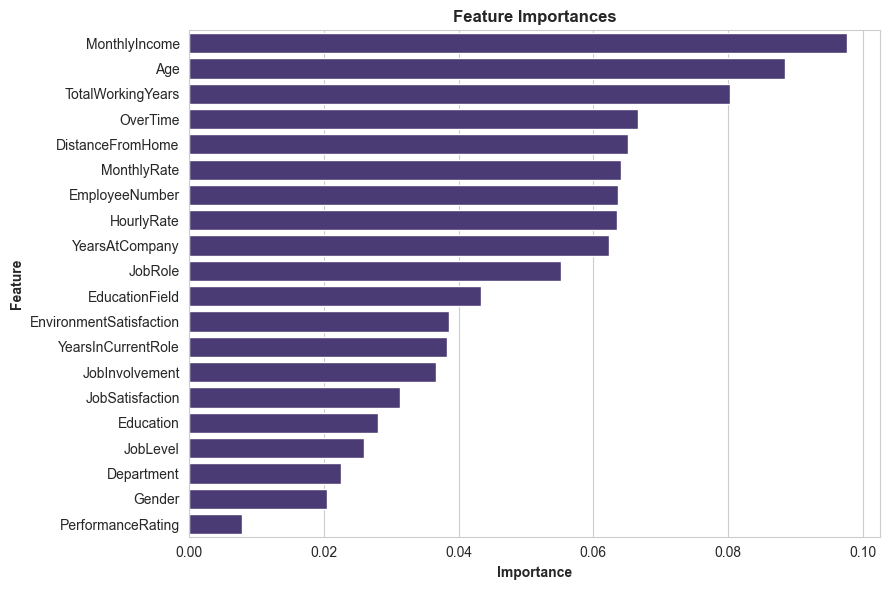

In [75]:
plt.figure(figsize=(9, 6))
ax = sns.barplot(data=importance_df, x='importance', y='feature')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

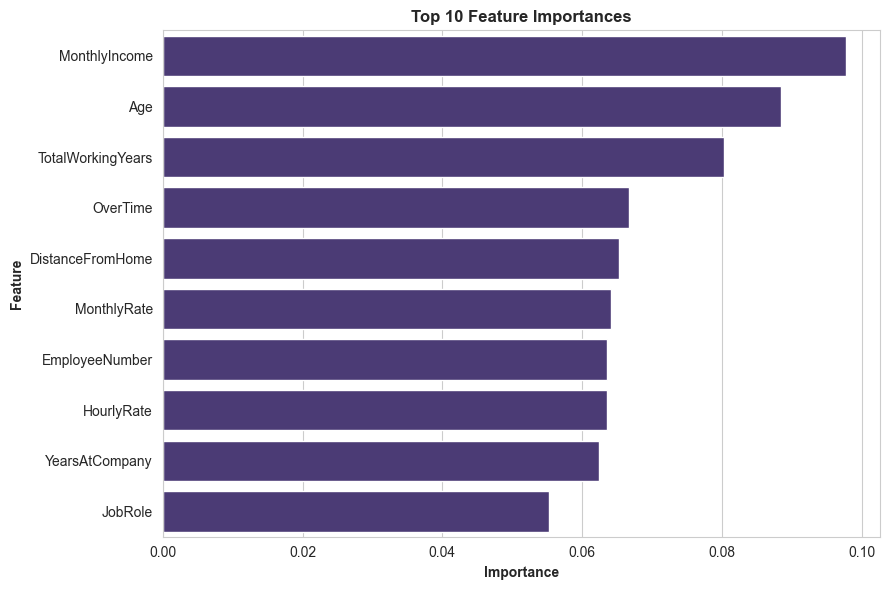

In [76]:
plt.figure(figsize=(9, 6))
sns.barplot(data=importance_df.head(10), x='importance', y='feature')
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

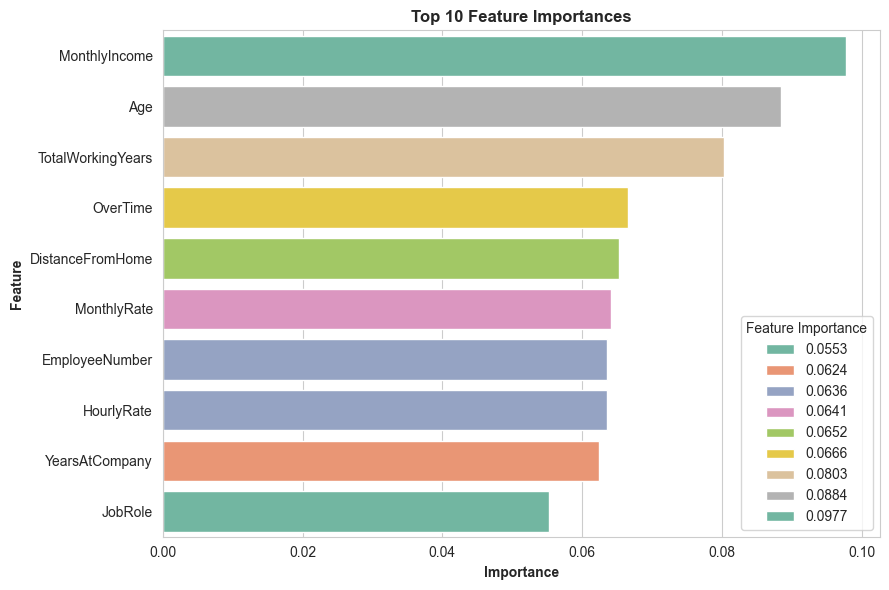

In [77]:
dummy = importance_df.head(10).copy()
dummy['importance'] = dummy['importance'].round(4)

plt.figure(figsize=(9, 6))
sns.barplot(data=dummy.head(10), x='importance', y='feature', hue='importance', palette='Set2')
plt.legend(title='Feature Importance')
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('../plots/BarPlotH_Top10Features.png')
plt.show()

In [78]:
models = {
    'GaussianNB': GaussianNB(),
    'BernoulliNB': BernoulliNB(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'SupportVectorClassifier': SVC(kernel='sigmoid', gamma=1.0),
    'DecisionTreeClassifier': DecisionTreeClassifier(max_depth=5),
    'XGBClassifier': XGBClassifier(n_estimators=50, random_state=42),
    'BaggingClassifier': BaggingClassifier(n_estimators=50, random_state=42),
    'LogisticRegression': LogisticRegression(solver='liblinear', penalty='l1'),
    'ExtraTreesClassifier': ExtraTreesClassifier(n_estimators=50, random_state=42),
    'RandomForestClassifier': RandomForestClassifier(n_estimators=50, random_state=42),
    'GradientBoostingClassifier': GradientBoostingClassifier(n_estimators=50, random_state=42),
    'AdaBoostClassifier': AdaBoostClassifier(n_estimators=50, algorithm='SAMME', random_state=42)
}

In [79]:
def train_classifier(model, X_train, y_train, X_test, y_test):
    model = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('classifier', model),
        ]
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy, model

In [80]:
model_count = len(models)
performance_metrics = []

for i, (name, model) in enumerate(models.items(), start=1):
    current_accuracy, current_model = train_classifier(model, X_train, y_train, X_test, y_test)
    if current_accuracy >= 0.85:
        pickle.dump(current_model, open(f'../models/{name}.pkl', 'wb'))
    performance_metrics.append({'Algorithm': name, 'Accuracy': current_accuracy})
    print(f'Complete {i}/{model_count} model: {name}')

performance_df = pd.DataFrame(performance_metrics).sort_values('Accuracy', ascending=False)

Complete 1/12 model: GaussianNB
Complete 2/12 model: BernoulliNB
Complete 3/12 model: KNeighborsClassifier
Complete 4/12 model: SupportVectorClassifier
Complete 5/12 model: DecisionTreeClassifier
Complete 6/12 model: XGBClassifier
Complete 7/12 model: BaggingClassifier
Complete 8/12 model: LogisticRegression
Complete 9/12 model: ExtraTreesClassifier
Complete 10/12 model: RandomForestClassifier
Complete 11/12 model: GradientBoostingClassifier
Complete 12/12 model: AdaBoostClassifier


In [81]:
performance_df

,Algorithm,Accuracy
7,LogisticRegression,0.870748
2,KNeighborsClassifier,0.846939
5,XGBClassifier,0.836735
6,BaggingClassifier,0.836735
9,RandomForestClassifier,0.836735
8,ExtraTreesClassifier,0.836735
4,DecisionTreeClassifier,0.829932
10,GradientBoostingClassifier,0.826531
11,AdaBoostClassifier,0.826531
1,BernoulliNB,0.819728


In [82]:
data = {
    'Gender': 'Female',
    'Department': 'Sales',
    'EducationField': 'Life Sciences',
    'JobRole': 'Sales Executive',
    'OverTime': 'Yes',
    'Age': 41,
    'DistanceFromHome': 1,
    'Education': 2,
    'EmployeeNumber': 1,
    'EnvironmentSatisfaction': 2,
    'HourlyRate': 94,
    'JobInvolvement': 3,
    'JobLevel': 2,
    'JobSatisfaction': 4,
    'MonthlyIncome': 5993,
    'MonthlyRate': 19479,
    'PerformanceRating': 3,
    'TotalWorkingYears': 8,
    'YearsAtCompany': 6,
    'YearsInCurrentRole': 4
}


data = pd.DataFrame([data])
model = pickle.load(open('../models/LogisticRegression.pkl', 'rb'))
prediction = model.predict(data)
print('Prediction:', prediction[0])

Prediction: 0
